## Which hospital group in the Austin/San Antonio TX area has the best prices?

![Big Data Ecosystem](https://media.npr.org/assets/img/2015/04/29/stagnes-exterior_wide-f590399293a2e93233700cfef9ddbafd4f873edd.jpg?s=600)

### 1. Motivation 
The Centers for Medicare and Medicaid Services (**CMMS**) require hospitals to publish a list of prices on their websites. Hospitals publish the files in different formats and with differing breakdowns of their prices. In most cases, the file is not easily accessible. It takes some searching to find them and the files usually are not consumer-friendly.

This analysis aimed to gather the data for all hospitals in the Austin/San Antonio TX region, transform it into a standard format and framework, and load it into a PostgreSQL database. Once there, we were able to analyze which hospital was the best relative value in different scenarios. 

### 1.1 Source Data

The first step was to compile a list of the hospitals in the Austin/San Antonio, TX area. The table with the listing of all hospitals is in `/volumes/data/dim`.

The next step was to visit each site and download the available files to comply with the CMMS ruling. You can find those raw files in `/volumes/data/raw`.

### 1.2 Ontology

Hospitals use different codings to publish their prices. We rely on the excellent work of the [Athena](https://athena.ohdsi.org/) vocabulary to define the ontology of healthcare procedures. This maps [CPT](https://www.ama-assn.org/practice-management/cpt) and [HCPCS](https://www.cms.gov/Medicare/Coding/MedHCPCSGenInfo) codes into a [common data model](https://github.com/OHDSI/CommonDataModel).

The disadvantage with this normalization is that we exclude the hospital-specific items such as their room and board charges, for example.

### 1.3 Transformation

The docker files in the repository run ETL transformations on the raw files, normalize the data and load it into a Postgres database. 

The hospitals include different types of prices. The four groups included in our analysis are:
* **gross**: The "list" price for a procedure. Hospitals typically never actually charge at this rate. 
* **cash**: The self-pay discounted price one would pay without insurance.
* **max**: The maximum negotiated rate by an insurance company in the hospital's network.
* **min**: The minimum negotiated rate by an insurance company in the hospital's network.

Most hospitals reported the de-identified maximum and minimum negotiated prices. A minority of them also included each insurance company's payer and plan-specific charges, but those are not in this version of the analysis.

### 1.4 Usage

Quickstart with docker-compose:  
`docker-compose up`

Run the flyway migrations:  
`docker-compose run flyway`

Run the ETL:  
`docker-compose run etl`

Interactive PostgreSQL client:  
`docker exec -it postgres psql -d postgres -U builder`

### Acknowledgements
This analysis is based on the work of **Nathan Sutton**. He started a repository for price transparency of hospitals in North Carolina. You can find his repository [here](https://github.com/nathansutton/hospital-price-transparency). Nate is also my mentor.

#### by Rogelio Montemayor

### 2. Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('dark')

from sqlalchemy import create_engine

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 3. Import Data & Exploratory Analysis
Once the container is running, we are ready to connect to the Postgres database.

In [2]:
db_string = f'postgresql://builder@localhost:5432/postgres'
engine = create_engine(db_string)

In [3]:
with engine.connect() as con:
    df = pd.read_sql_query("""
    SELECT p.concept_id,
           c.concept_name AS procedure,
           p.price,
           p.amount,
           p.hospital_id,
           h.hospital_name,
           h.affiliation AS hospital_group
      FROM price p
      JOIN hospital h
           USING(hospital_id)
      JOIN concept c
           ON c.concept_id = p.concept_id
      ORDER BY 5
      """, con)

The file returned has almost 1 million rows. It includes the following columns:

* **concept_id**: This is the code that uniquely identifies the procedure 
* **procedure**: The procedure's name
* **price**: The type of price (gross, cash, max and min)
* **amount**: The amount in dollars
* **hospital_id**: This code comes from the hospitals table
* **hospital_name**: The name of the hospital
* **hospital_group**: The group that the hospital belongs to (when that is the case)

In [4]:
display(df.head())

,concept_id,procedure,price,amount,hospital_id,hospital_name,hospital_group
0,41965134,Vauxrezis,max,367.4166,2,ASCENSION SETON BASTROP,Ascencion Health
1,2514579,Home visit for stoma care and maintenance incl...,max,153.2133,2,ASCENSION SETON BASTROP,Ascencion Health
2,46257482,Advance care planning including the explanatio...,max,230.9274,2,ASCENSION SETON BASTROP,Ascencion Health
3,43528032,Transitional Care Management Services with the...,max,364.9449,2,ASCENSION SETON BASTROP,Ascencion Health
4,2514495,Prolonged service in the inpatient or observat...,max,300.6807,2,ASCENSION SETON BASTROP,Ascencion Health


In [5]:
display(df.shape)

(948337, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948337 entries, 0 to 948336
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   concept_id      948337 non-null  int64  
 1   procedure       948337 non-null  object 
 2   price           948337 non-null  object 
 3   amount          948337 non-null  float64
 4   hospital_id     948337 non-null  int64  
 5   hospital_name   948337 non-null  object 
 6   hospital_group  948337 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 50.6+ MB


We can see that the average price of a procedure for this group of hospitals is over 6,600. The median price is around one thousand dollars.

In [7]:
display(df.describe())

,concept_id,amount,hospital_id
count,9.483370e+05,9.483370e+05,948337.000000
mean,7.523852e+06,6.616047e+03,39.127176
std,1.326917e+07,1.902805e+04,21.801843
min,2.800000e+02,2.500000e-03,2.000000
25%,2.212320e+06,1.857700e+02,18.000000
50%,2.615740e+06,1.073000e+03,43.000000
75%,2.718563e+06,5.100000e+03,56.000000
max,4.625776e+07,2.170900e+06,76.000000


The maximum price over all is 2.17 million dollars. (The price Methodist Hospital quotes on their list for Axicabtagene and Tisagenlecleucel, two cancer treatments, if you were to pay cash).

In [8]:
df.loc[df.amount == df.amount.max()]

,concept_id,procedure,price,amount,hospital_id,hospital_name,hospital_group
503955,40664685,"Axicabtagene ciloleucel, up to 200 million aut...",cash,2170899.5,46,METHODIST HOSPITAL,HCA Healthcare
505426,40664685,"Axicabtagene ciloleucel, up to 200 million aut...",gross,2170899.5,46,METHODIST HOSPITAL,HCA Healthcare
525502,40664686,"Tisagenlecleucel, up to 600 million car-positi...",gross,2170899.5,46,METHODIST HOSPITAL,HCA Healthcare
530886,40664686,"Tisagenlecleucel, up to 600 million car-positi...",cash,2170899.5,46,METHODIST HOSPITAL,HCA Healthcare


#### 3.1 First Approach: Common Procedures

To understand which hospital group has the best prices, we first need to find common procedures to compare them. My first approach was to research the prices charged by the different hospitals for the most common procedures performed by hospitals.

According to The Healthcare Cost and Utilization Project ([HCUP](https://www.hcup-us.ahrq.gov)), these were the [most common inpatient procedures in 2018](https://www.hcup-us.ahrq.gov/faststats/NationalProceduresServlet):

|Procedure|Total Stays|Stays per 100k|
|---:|---:|---:|
|Knee Arthroplasty | 715,203 | 219 |
|Episiotomy| 688,375 | 211 |
|Hip Arthroplasty | 599,494 | 184 |
|Angioplasty | 481,780 | 148 |
|Spine Fusion | 455,505 | 140 |
|Femur Fixation| 307,275 | 94 |
|Colectomy| 298,650 | 92 |
|Vertebral Discectomy | 285,635 | 88 |
|Subcutaneour tissue and fascia excision| 239,325 | 73 |
|Bone excision | 227,325 | 70 |

The next step was to get a CPT code for each procedure. In reality, there are multiple codes for each operation, so I settled on the ones that appeared more often.

In [9]:
# According to H-CUP for 2018
common_codes = [2105103, 2110308, 2104836, 43527994, 42742494, 2104281, 2109065, 2110644, 2101925, 2105545]

In [10]:
short_names = ['knee arthroplasty', 'episiotomy', 'hip arthroplasty', 'angioplasty', 'arthrodesis', 
               'fixation', 'colectomy', 'discectomy', 'debridement', 'ostectomy']

As you can see in the following graphs, there is a significant disparity in prices for the same procedure across hospitals. 

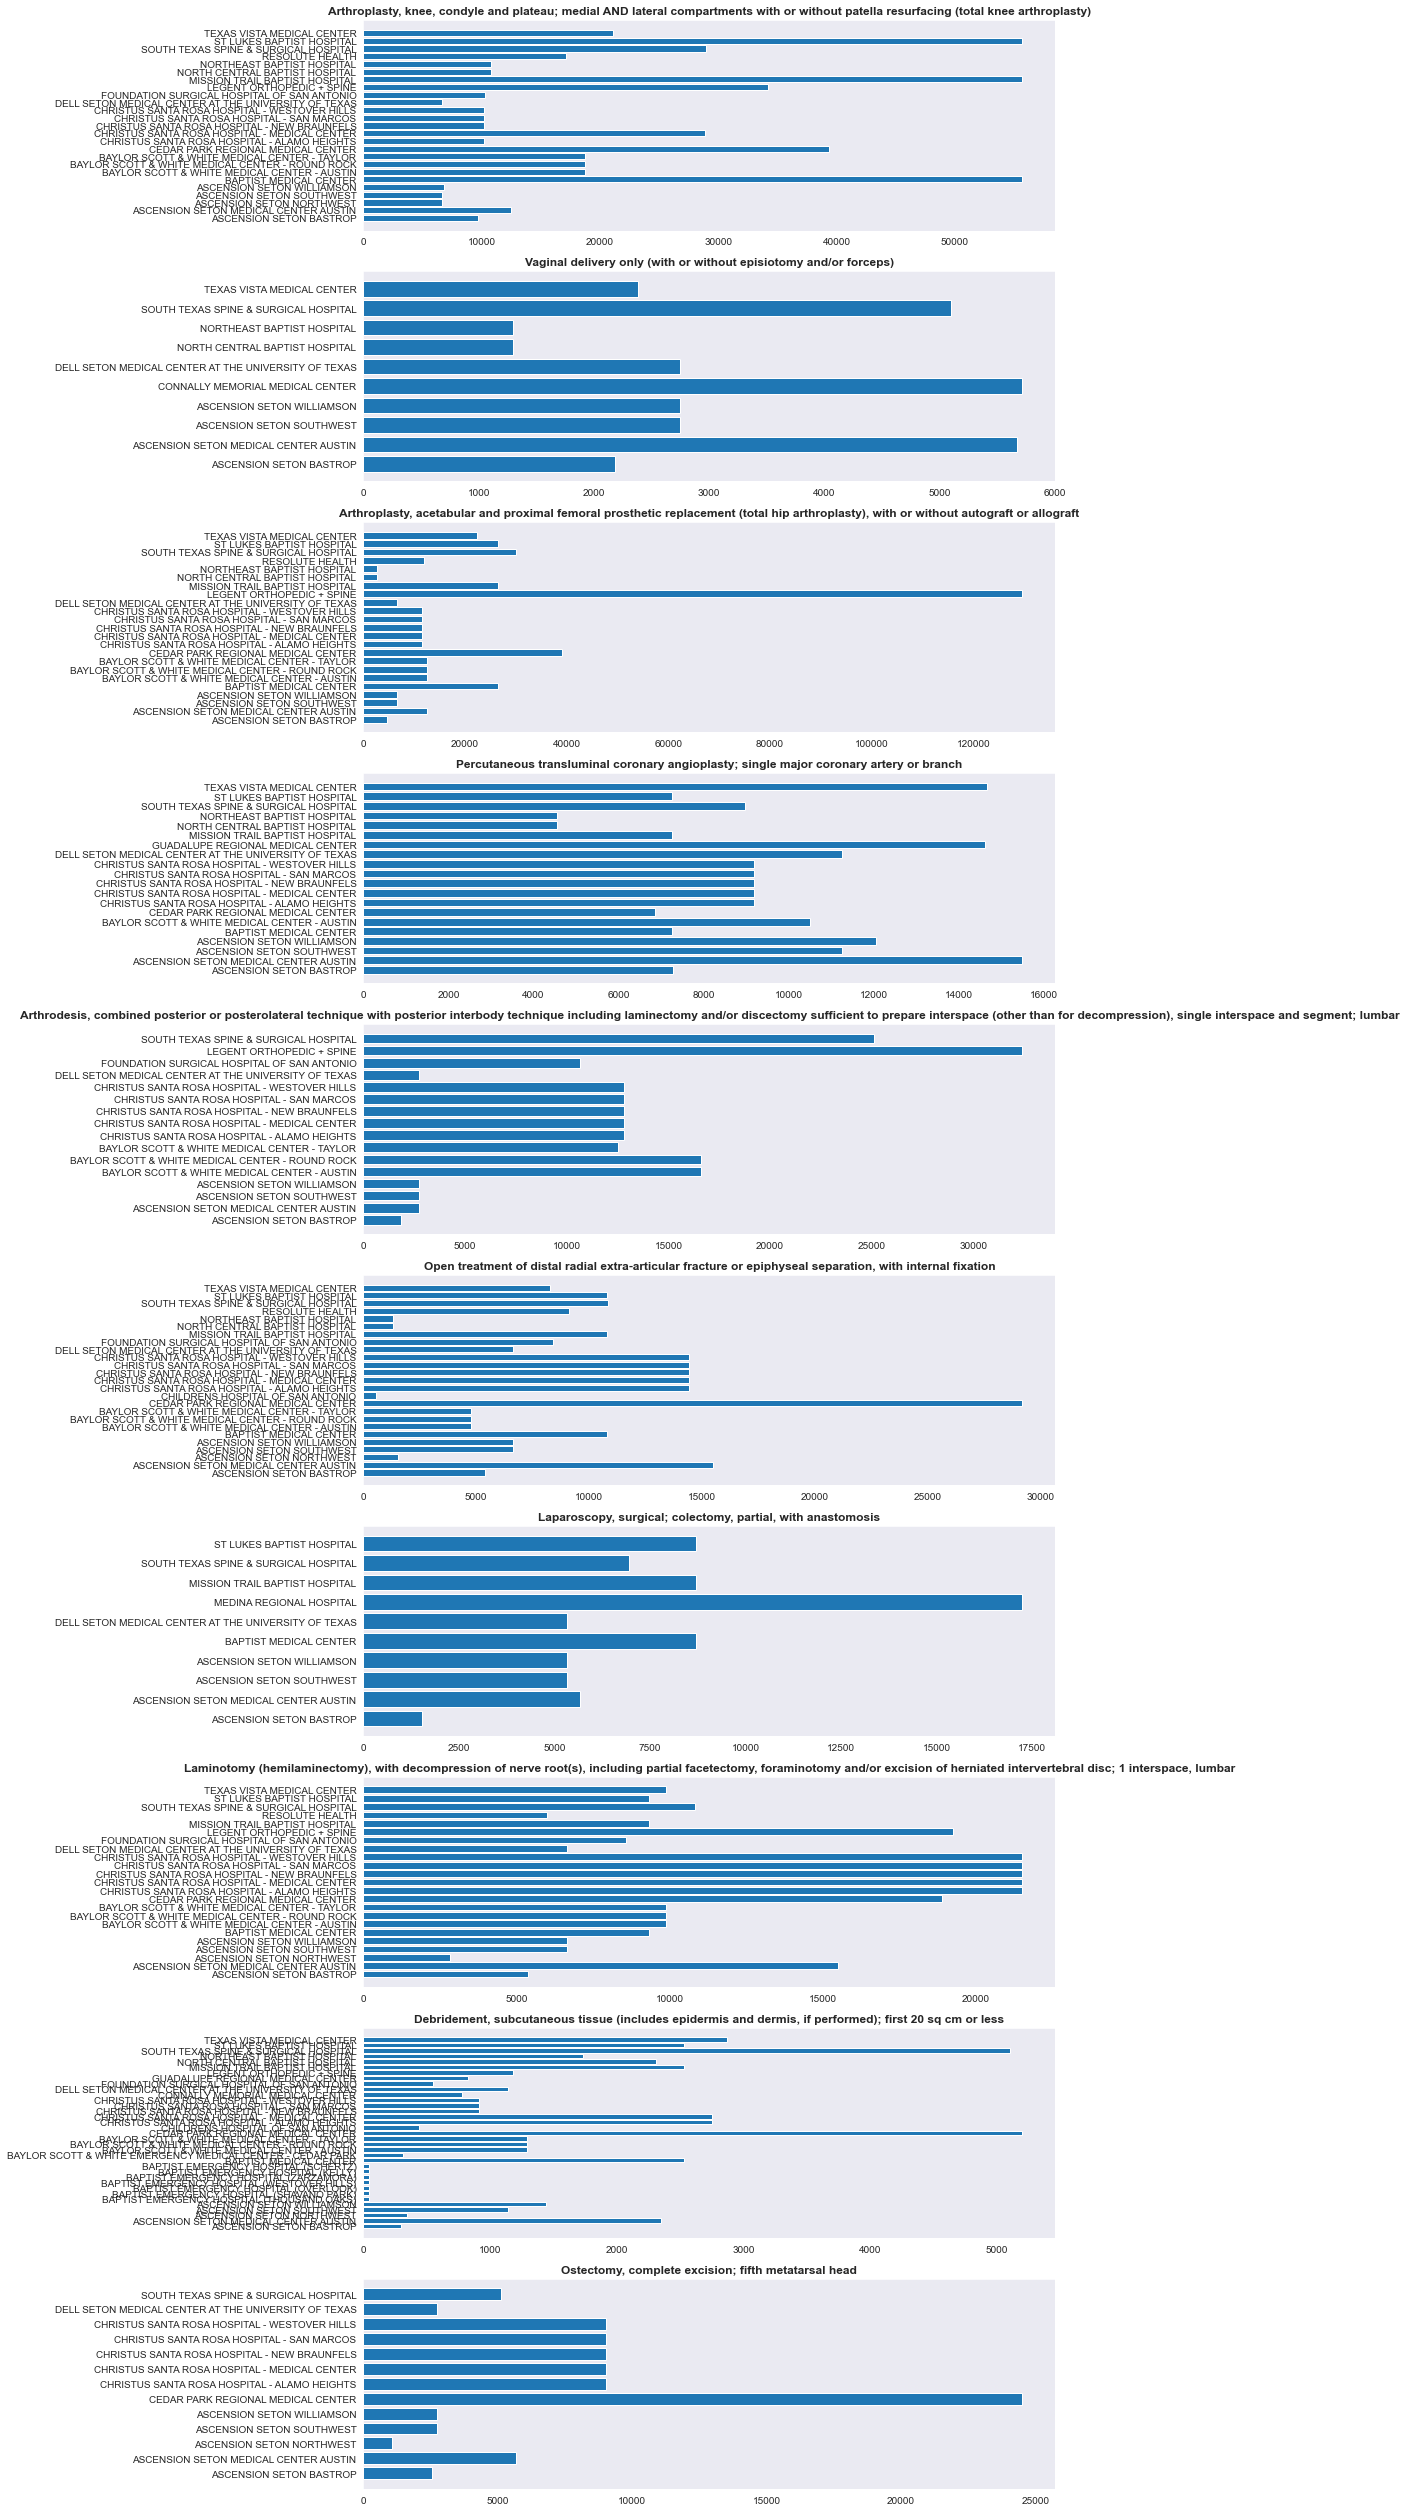

In [11]:
plt.figure(figsize=(15,35))
for i, code in enumerate(common_codes):
    temp_df = df[(df.concept_id == code) & (df.price == 'max')]
    temp_df = temp_df.drop_duplicates(subset=['procedure', 'price', 'hospital_id'])
    procedure = temp_df.procedure.values[0]
    plt.subplot(10,1,i+1)
    plt.barh('hospital_name', 'amount', data=temp_df)
    plt.title(f'{procedure}', fontweight='bold')
plt.tight_layout()
plt.show()

#### 3.2 Better approach: What are the codes that appear for most hospital groups?

Instead of fixing the procedures/codes and finding the ones that appear in most hospitals, we approached the problem from the other end. 

There are more than 16 thousand unique codes in the data:

In [12]:
all_codes = df.concept_id.unique()
display(len(all_codes))

16120

We can then group by hospital group and get the 30 codes that show up in almost every hospital group:

In [13]:
p_codes = []
for code in all_codes:
    if len(df.loc[df.concept_id == code, 'hospital_group'].value_counts().values) > 12:
        p_codes.append(code)

In [14]:
display(len(p_codes))

30

In [15]:
p_codes.sort()
popular = df.concept_id.isin(p_codes)
popular_procedures = df[popular]

The following table, with 6,500 rows, shows those 30 procedures for the different price types and across all hospitals.

In [16]:
display(popular_procedures.head())

,concept_id,procedure,price,amount,hospital_id,hospital_name,hospital_group
274,2212470,Natriuretic peptide,min,55.3080,2,ASCENSION SETON BASTROP,Ascencion Health
766,2212453,Magnesium,max,26.5467,2,ASCENSION SETON BASTROP,Ascencion Health
1740,2212996,"Culture, bacterial; quantitative colony count,...",max,31.9716,2,ASCENSION SETON BASTROP,Ascencion Health
1764,2314285,"Therapeutic procedure, 1 or more areas, each 1...",max,114.0513,2,ASCENSION SETON BASTROP,Ascencion Health
2077,2212453,Magnesium,min,10.9164,2,ASCENSION SETON BASTROP,Ascencion Health


In [17]:
display(popular_procedures.shape)

(6571, 7)

### 4. Procedures by Hospital Group

We'll run a new query that gets the prices for those 30 procedures by hospital group (instead of by hospital).

#### 4.1 Gross prices
We first run this search using **gross** prices.

Note: I will be leaving out Ascencion Health's hospitals because they did not provide gross prices.

In [18]:
with engine.connect() as con:
    df2 = pd.read_sql_query("""
    SELECT DISTINCT
           p.concept_id, 
           c.concept_name AS procedure,
           CEILING(CASE WHEN p.price = 'gross' AND h.affiliation = 'Tenet Health' THEN p.amount ELSE NULL END) AS "Tenet",
           CEILING(CASE WHEN p.price = 'gross' AND h.affiliation = 'Baylor Scott & White Health' THEN p.amount ELSE NULL END) AS "Baylor",
           CEILING(CASE WHEN p.price = 'gross' AND h.affiliation = 'Christus Health' THEN p.amount ELSE NULL END) AS "Christus",
           CEILING(CASE WHEN p.price = 'gross' AND h.affiliation = 'HCA Healthcare' THEN p.amount ELSE NULL END) AS "HCA",
           CEILING(CASE WHEN p.price = 'gross' AND h.affiliation = 'University Health System' THEN p.amount ELSE NULL END) AS "University"
      FROM price p
      JOIN hospital h
           USING(hospital_id)
      JOIN concept c
           ON c.concept_id = p.concept_id
     WHERE p.concept_id IN (725068, 2211327, 2211353, 2211424, 2211765, 2212090, 2212093, 2212095,
                            2212096, 2212099, 2212124, 2212166, 2212453, 2212470, 2212523, 2212542,
                            2212572, 2212593, 2212649, 2212731, 2212737, 2212980, 2212996, 2213039,
                            2313773, 2314284, 2314285, 2314294, 41939096, 41954152)
      """, con)

In [19]:
display(df2.head())

,concept_id,procedure,Tenet,Baylor,Christus,HCA,University
0,725068,"Radiologic examination, chest; single view",729.0,NaN,NaN,NaN,NaN
1,725068,"Radiologic examination, chest; single view",856.0,NaN,NaN,NaN,NaN
2,725068,"Radiologic examination, chest; single view",928.0,NaN,NaN,NaN,NaN
3,725068,"Radiologic examination, chest; single view",937.0,NaN,NaN,NaN,NaN
4,725068,"Radiologic examination, chest; single view",955.0,NaN,NaN,NaN,NaN


In [20]:
display(df2.shape)

(563, 7)

We then transform this 563 lines into a more compact table with the median price for each hospital group. Each row represents a hospital group. 

In [21]:
# get the median values for each hospital group and transpose
df2_grouped = df2.groupby(['concept_id'], as_index=False).median()
df2_pivot = df2_grouped.iloc[:,1:].T

# column names are procedure codes and sort by row totals
df2_pivot.rename(columns=df2_grouped.concept_id, inplace=True)
df2_pivot = df2_pivot.iloc[df2_pivot.sum(axis=1).argsort()]

display(df2_pivot)

,725068,2211327,2211353,2211424,2211765,2212090,2212093,2212095,2212096,2212099,2212124,2212166,2212453,2212470,2212523,2212542,2212572,2212593,2212649,2212731,2212737,2212980,2212996,2213039,2313773,2314284,2314285,2314294,41939096,41954152
University,368.0,1928.0,5063.0,2386.0,467.0,92.0,140.0,107.0,129.0,107.0,142.0,39.0,146.0,117.0,54.0,171.0,27.0,83.0,41.0,131.0,30.0,70.0,76.0,68.0,387.0,165.0,164.0,165.0,5063.0,467.0
Baylor,313.5,2159.0,4917.0,2831.0,700.5,243.0,308.0,180.5,115.0,354.0,358.5,67.5,143.5,338.0,78.5,243.0,63.5,178.5,143.0,97.0,110.0,254.0,180.0,106.0,643.0,195.0,205.0,227.0,4917.0,700.5
Christus,591.0,2148.0,7362.0,2071.0,1303.5,345.0,424.5,305.0,336.5,283.0,232.0,231.5,143.0,338.0,87.0,176.0,80.0,245.5,141.0,116.5,104.5,399.0,371.0,160.5,752.5,154.0,206.5,200.5,7362.0,1303.5
HCA,760.0,4419.5,7828.0,4725.5,992.0,798.5,1005.0,753.0,831.5,934.0,560.5,295.0,299.0,525.0,269.0,438.5,202.0,603.0,279.0,304.0,278.0,661.0,471.0,223.0,632.0,360.0,374.0,398.5,7828.0,992.0
Tenet,928.0,4935.0,11155.5,7860.0,1963.0,820.0,1352.0,681.0,477.0,808.0,772.0,364.0,255.5,621.0,205.5,437.5,133.0,615.0,298.0,248.0,209.0,548.0,323.0,291.0,794.5,199.0,569.0,300.5,11155.5,1963.0


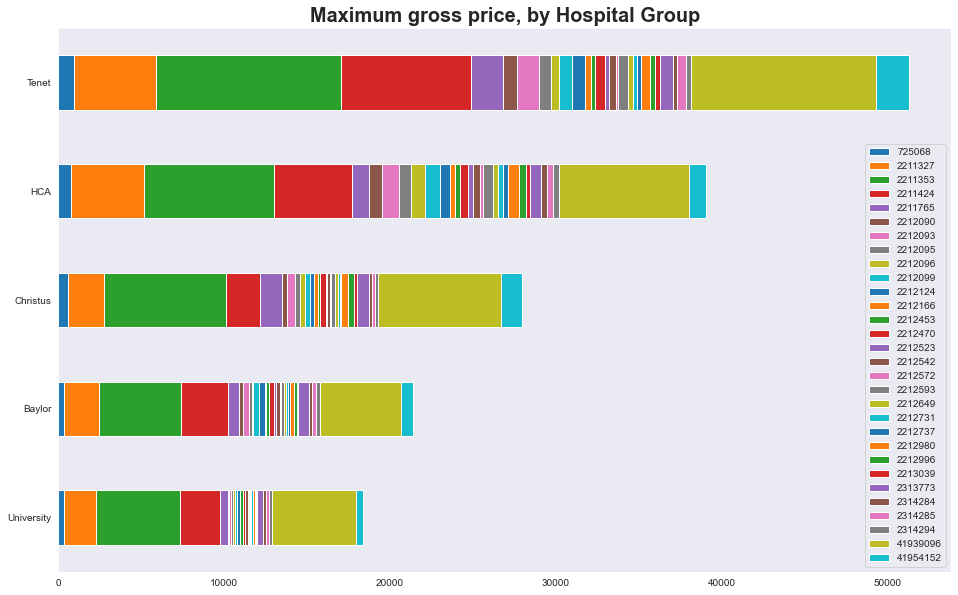

In [22]:
df2_pivot.plot(kind='barh', stacked=True, figsize=(16,10))
plt.title('Maximum gross price, by Hospital Group', fontsize=20, fontweight='bold')
plt.show()

In this analysis, University hospital is the best choice. 

The problem with using gross prices is that one could say that they are "list" prices that are never typically used to charge a patient. A more realistic way of comparing would be to use max prices, the actual maximum price that any insurance payer gets billed for the procedure. 

#### 4.2 Maximum negotiated prices

We can say that a hospital would never bill an insured patient above the posted maximum price.

Note. This time we will leave university hospitals and HCA hospitals out because they did not provide max prices:

In [23]:
with engine.connect() as con:
    df3 = pd.read_sql_query("""
    SELECT DISTINCT
           p.concept_id, 
           c.concept_name,
           CEILING(CASE WHEN p.price = 'max' AND h.affiliation = 'Ascencion Health' THEN p.amount ELSE NULL END) AS "Ascencion",
           CEILING(CASE WHEN p.price = 'max' AND h.affiliation = 'Tenet Health' THEN p.amount ELSE NULL END) AS "Tenet",
           CEILING(CASE WHEN p.price = 'max' AND h.affiliation = 'Baylor Scott & White Health' THEN p.amount ELSE NULL END) AS "Baylor",
           CEILING(CASE WHEN p.price = 'max' AND h.affiliation = 'Christus Health' THEN p.amount ELSE NULL END) AS "Christus"
      FROM price p
      JOIN hospital h
           USING(hospital_id)
      JOIN concept c
           ON c.concept_id = p.concept_id
     WHERE p.concept_id IN (725068, 2211327, 2211353, 2211424, 2211765, 2212090, 2212093, 2212095,
                            2212096, 2212099, 2212124, 2212166, 2212453, 2212470, 2212523, 2212542,
                            2212572, 2212593, 2212649, 2212731, 2212737, 2212980, 2212996, 2213039,
                            2313773, 2314284, 2314285, 2314294, 41939096, 41954152)
      """, con)

In [24]:
df3.head()

,concept_id,concept_name,Ascencion,Tenet,Baylor,Christus
0,725068,"Radiologic examination, chest; single view",22.0,NaN,NaN,NaN
1,725068,"Radiologic examination, chest; single view",60.0,NaN,NaN,NaN
2,725068,"Radiologic examination, chest; single view",200.0,NaN,NaN,NaN
3,725068,"Radiologic examination, chest; single view",1462.0,NaN,NaN,NaN
4,725068,"Radiologic examination, chest; single view",NaN,50.0,NaN,NaN


In [25]:
# get the median values for each hospital group and transpose
df3_grouped = df3.groupby(['concept_id'], as_index=False).median()
df3_pivot = df3_grouped.iloc[:,1:].T

# column names are procedure codes and sort by row totals
df3_pivot.rename(columns=df3_grouped.concept_id, inplace=True)
df3_pivot = df3_pivot.iloc[df3_pivot.sum(axis=1).argsort()]

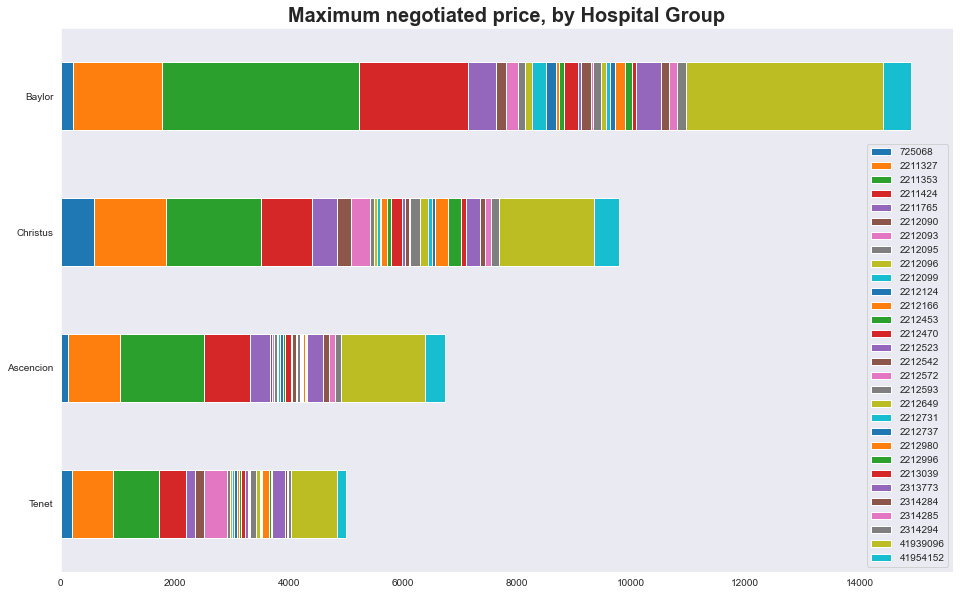

In [26]:
df3_pivot.plot(kind='barh', stacked=True, figsize=(16,10))
plt.title('Maximum negotiated price, by Hospital Group', fontsize=20, fontweight='bold')
plt.show()

#### The best bet for an insured patient in the Austin/San Antonio are is to go to Tenet hospitals.

In the next table, we present the description of each of those 30 most used codes.

#### 4.3 Procedures Table

In [27]:
procedures = [df2.procedure[df2.concept_id == code].values[0] for code in p_codes]

In [28]:
pd.set_option('display.max_colwidth', 150)
legend = pd.DataFrame({'code_id' : p_codes, 'Procedure': procedures})
display(legend)

,code_id,Procedure
0,725068,"Radiologic examination, chest; single view"
1,2211327,"Computed tomography, head or brain; without contrast material"
2,2211353,"Magnetic resonance (eg, proton) imaging, brain (including brain stem); without contrast material, followed by contrast material(s) and further seq..."
3,2211424,"Computed tomography, pelvis; with contrast material(s)"
4,2211765,"Ultrasound, transvaginal"
5,2212090,"Basic metabolic panel (Calcium, total) This panel must include the following: Calcium, total (82310) Carbon dioxide (bicarbonate) (82374) Chloride..."
6,2212093,"Comprehensive metabolic panel This panel must include the following: Albumin (82040) Bilirubin, total (82247) Calcium, total (82310) Carbon dioxid..."
7,2212095,"Lipid panel This panel must include the following: Cholesterol, serum, total (82465) Lipoprotein, direct measurement, high density cholesterol (HD..."
8,2212096,"Renal function panel This panel must include the following: Albumin (82040) Calcium, total (82310) Carbon dioxide (bicarbonate) (82374) Chloride (..."
9,2212099,"Hepatic function panel This panel must include the following: Albumin (82040) Bilirubin, total (82247) Bilirubin, direct (82248) Phosphatase, alka..."


#### 4.4 Which hospitals are in each hospital group?

The following is a list of the hospitals included for each hospital group:

In [29]:
hospital_groups = ['HCA Healthcare', 'University Health System', 'Baylor Scott & White Health', 'Christus Health', 'Ascencion Health', 'Tenet Health']
for hospital_group in hospital_groups:
    print(f'{hospital_group:^40s}')
    print('-'*40)
    print(*df.hospital_name[df.hospital_group == hospital_group].unique().tolist(), sep='\n')
    print()

             HCA Healthcare             
----------------------------------------
HEART HOSPITAL OF AUSTIN, A CAMPUS OF ST DAVIDS MEDICAL CENTER
METHODIST AMBULATORY SURGERY HOSPITAL-NORTHWEST
METHODIST HOSPITAL
METHODIST HOSPITAL SOUTH
METHODIST HOSPITAL STONE OAK REHABILITATION CENTER
METHODIST SPECIALTY & TRANSPLANT HOSPITAL
METHODIST STONE OAK  HOSPITAL
METHODIST TEXSAN HOSPITAL, A METHODIST HOSPITAL FACILITY
METROPOLITAN METHODIST HOSPITAL
NORTH AUSTIN MEDICAL CENTER
NORTHEAST METHODIST HOSPITAL
ROUND ROCK  MEDICAL CENTER
ST DAVIDS GEORGETOWN HOSPITAL  A ST DAVIDS MEDICAL CENTER FACILI
ST DAVIDS MEDICAL CENTER
ST DAVIDS REHABILITATION HOSPITAL, A ST DAVIDS  MEDICAL CENTER
ST DAVIDS SOUTH AUSTIN MEDICAL CENTER
ST DAVIDS SURGICAL HOSPITAL A CAMPUS OF NORTH AUSTIN MEDICAL CTR

        University Health System        
----------------------------------------
UNIVERSITY HOSPITAL SYSTEM

      Baylor Scott & White Health       
----------------------------------------
BAYLOR SCOTT & WHI

### 5. Conclusion & Insights

The present analysis sheds some light on the relative pricing of hospitals in the Austin/San Antonio area of Texas. We can see how the Tenet group of hospitals seem to have lower maximum negotiated prices than other hospital groups for the 30 most common procedures.

If a patient wants to know the price of a particular procedure, we could run the analysis just for that procedure. An alternative would be to use [Turquoise Health's](https://turquoise.health) consumer-friendly lookup tool to lookup reported prices in different hospital systems interactively.

Transparency helps everyone. Consumers can vote with their dollars, and insurance companies can negotiate better on behalf of their customers. Hospital systems can also benefit and benchmark their costs and prices to spot inefficiencies and areas of improvement. 

Everyone benefits from more and deeper transparency. A significant next step would be to converge as an industry into a more standard way of reporting, calculating prices, and communicating with their customers.

### Bonus Analysis

#### What if I am looking for a head cat scan and will pay cash?

The following is an example of a lookup of just one procedure. 

First we lookup the code for computed tomographies.

In [30]:
ct_scan_codes = df[df.procedure.str.contains('computed tomography', case=False)
                  & df.procedure.str.contains('head')].concept_id.unique().tolist()
ct_scan_codes.sort()
ct_procedures = [df.procedure[df.concept_id == code].values[0] for code in ct_scan_codes]
legend2 = pd.DataFrame({'code_id' : ct_scan_codes, 'Procedure': ct_procedures})
display(legend2)

,code_id,Procedure
0,2211327,"Computed tomography, head or brain; without contrast material"
1,2211328,"Computed tomography, head or brain; with contrast material(s)"
2,2211329,"Computed tomography, head or brain; without contrast material, followed by contrast material(s) and further sections"
3,2212056,Positron emission tomography (PET) with concurrently acquired computed tomography (CT) for attenuation correction and anatomical localization imag...


From this list we pick 2211327 for a ct scan without contrast material. Then we run the next query:

In [31]:
with engine.connect() as con:
    df4 = pd.read_sql_query("""
    SELECT DISTINCT
           p.concept_id, 
           c.concept_name AS procedure,
           CEILING(CASE WHEN p.price = 'cash' AND h.affiliation = 'Tenet Health' THEN p.amount ELSE NULL END) AS "Tenet",
           CEILING(CASE WHEN p.price = 'cash' AND h.affiliation = 'Baylor Scott & White Health' THEN p.amount ELSE NULL END) AS "Baylor",
           CEILING(CASE WHEN p.price = 'cash' AND h.affiliation = 'Christus Health' THEN p.amount ELSE NULL END) AS "Christus",
           CEILING(CASE WHEN p.price = 'cash' AND h.affiliation = 'HCA Healthcare' THEN p.amount ELSE NULL END) AS "HCA"
      FROM price p
      JOIN hospital h
           USING(hospital_id)
      JOIN concept c
           ON c.concept_id = p.concept_id
     WHERE p.concept_id  = 2211327
      """, con)

In [32]:
df4.head()

,concept_id,procedure,Tenet,Baylor,Christus,HCA
0,2211327,"Computed tomography, head or brain; without contrast material",3407.0,NaN,NaN,NaN
1,2211327,"Computed tomography, head or brain; without contrast material",3683.0,NaN,NaN,NaN
2,2211327,"Computed tomography, head or brain; without contrast material",3702.0,NaN,NaN,NaN
3,2211327,"Computed tomography, head or brain; without contrast material",3792.0,NaN,NaN,NaN
4,2211327,"Computed tomography, head or brain; without contrast material",4348.0,NaN,NaN,NaN


In [33]:
# get the median values for each hospital group and transpose
df4_grouped = df4.groupby(['concept_id'], as_index=False).median()
df4_pivot = df4_grouped.iloc[:,1:].T

# column names are procedure codes and sort by row totals
df4_pivot.rename(columns=df4_grouped.concept_id, inplace=True)
df4_pivot = df4_pivot.iloc[df4_pivot.sum(axis=1).argsort()]

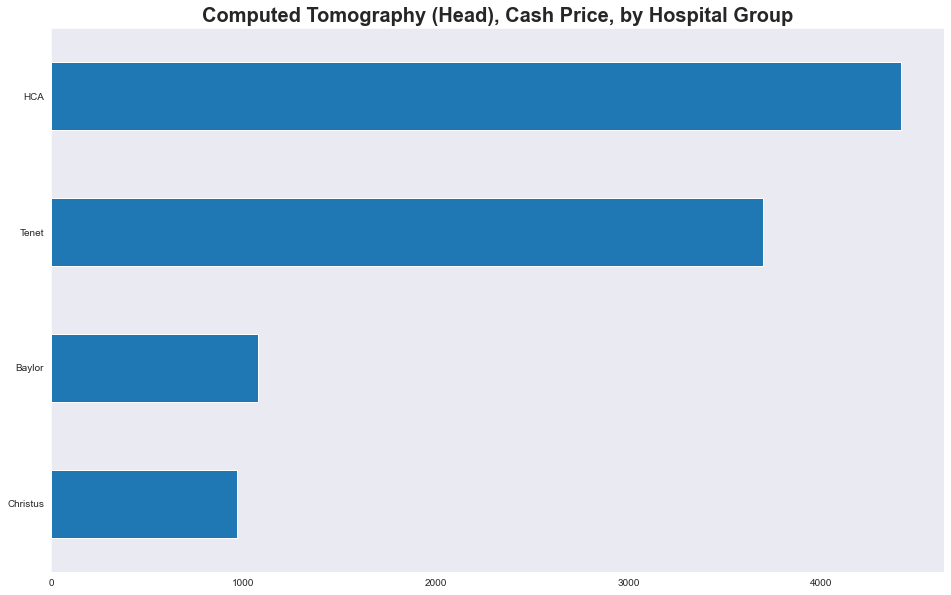

In [34]:
df4_pivot.plot(kind='barh', stacked=True, figsize=(16,10), legend=False)
plt.title('Computed Tomography (Head), Cash Price, by Hospital Group', fontsize=20, fontweight='bold')
plt.show()